In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split

csv = ['/RegularSeasonCompactResults.csv',
'/RegularSeasonDetailedResults.csv',
'/Seasons.csv',
'/Teams.csv',
'/TourneyCompactResults.csv',
'/TourneyDetailedResults.csv',
'/TourneySeeds.csv',
'/TourneySlots.csv',
'/sample_submission.csv']
direct = 'C:/Users/danil/Downloads/Data/March_Madness'
sea_det = pd.read_csv(direct+csv[1])
sea_det.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [129]:
#sea_det.drop(labels = ['Numot','Daynum','Wloc'],inplace=True, axis=1)
#sea_det[sea_det['Wteam'] == 1104].head()
sea_det = sea_det[sea_det['Season']>=2009]
sea_det.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
28825,2009,7,1181,80,1342,49,H,0,30,63,...,17,14,19,10,19,4,28,5,5,25
28826,2009,7,1204,65,1222,63,N,0,24,62,...,20,16,27,15,22,9,14,6,2,21
28827,2009,8,1181,97,1204,54,H,0,32,66,...,19,13,21,16,20,6,17,5,6,28
28828,2009,8,1222,76,1342,57,N,0,30,56,...,21,19,24,8,20,8,19,5,3,18
28829,2009,8,1318,73,1237,60,N,0,21,50,...,17,18,26,13,19,7,9,3,4,22


In [48]:
def get_past(num, season, team):
    df = sea_det[(sea_det['Wteam'] == team) | (sea_det['Lteam'] == team)]
    df = df[df['Season'] == season]
    df = df.sort_values(by = ['Daynum'])
    df_1 = df.iloc[-num:]
    wins = np.sum([df.iloc[-num:]['Wteam'] == team])
    win_pct = wins/len(df.iloc[-num:]['Wteam'] == team)
    
    Wfgp_n = np.mean((df_1['Wfgm']/df_1['Wfga']))
    Wfg3p_n = np.mean((df_1['Wfgm3']/df_1['Wfga3']))
    Wftp_n = np.mean((df_1['Wftm']/df_1['Wfta']))
    
    return win_pct, Wfgp_n, Wfg3p_n, Wftp_n

In [118]:
import math
base_elo = 1600
team_elos = pd.DataFrame()
for i in range(2009, 2017):
    for j in sea_det['Wteam'].unique():
        x = []
        x.append(i)
        x.append(j)
        x.append(1600)
        team_elos = team_elos.append([x], ignore_index= True)
team_elos.columns = ['Season','Team','Elo']

def calc_elo(win_team, lose_team, season):
    
    season_df = team_elos[team_elos['Season'] == season]
    winner_rank = season_df[season_df['Team'] == win_team].values[0][2]
    loser_rank = season_df[season_df['Team'] == lose_team].values[0][2]

    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    new_loser_rank = loser_rank - new_rank_diff
    
    win_index = team_elos.loc[(team_elos['Season'] == season) & (team_elos['Team'] == win_team)].index
    lose_index = team_elos.loc[(team_elos['Season'] == season) & (team_elos['Team'] == lose_team)].index
    
    team_elos.set_value(win_index,'Elo',new_winner_rank)
    team_elos.set_value(lose_index,'Elo',new_loser_rank)
        


# def get_elo(season, team):
#     try:
#         return team_elos[season][team]
#     except:
#         try:
#             # Get the previous season's ending value.
#             team_elos[season][team] = team_elos[season-1][team]
#             return team_elos[season][team]
#         except:
#             # Get the starter elo.
#             return 1600
# def get_elo(season, team):
    
        
# x = sea_det[sea_det['Season'] >= 2015]
# y=[]
# for i in range(0,len(sea_det)):
#     win = sea_det['Wteam'][i]
#     lose = sea_det['Lteam'][i]
#     season = sea_det['Season'][i]
#     y.append(calc_elo(win,lose,season))


In [119]:
for ii, row in sea_det.iterrows():
    win = row['Wteam']
    lose = row['Lteam']
    season = row['Season']
    (calc_elo(win,lose,season))


In [121]:
team_elos.tail(20)

,Season,Team,Elo
2804,2016,1164,1449.0
2805,2016,1223,1556.0
2806,2016,1341,1446.0
2807,2016,1380,1626.0
2808,2016,1457,1689.0
2809,2016,1258,1571.0
2810,2016,1411,1628.0
2811,2016,1290,1424.0
2812,2016,1422,1563.0
2813,2016,1185,1631.0


In [89]:
season_df = team_elos[team_elos['Season'] == 2015]
elo = season_df[season_df['Team'] == 1181].values[0][2]
x = team_elos.loc[(team_elos['Season'] == 2015) & (team_elos['Team'] == 1122)].index
x

Int64Index([1569], dtype='int64')

In [25]:
# sea_det[sea_det['Wteam'] == 1104].iloc[-3:]
# sea_det[sea_det['Wteam'] == 1104].tail()
# df = sea_det[(sea_det['Wteam'] == 1222) | (sea_det['Lteam'] == 1222)]
# df_1 = df.iloc[-10:]
# df_1

(0.59999999999999998, 0.489316279200043, 0.39273689975688897, 0.7098169862880007)


In [170]:
#make new table 
wins = pd.DataFrame()
wins_col = ['Season','Wteam', 'Wfgm', 'Wfga', 'Wfgm3', 'Wfga3', 'Wftm',
       'Wfta', 'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk', 'Wpf','Wscore','Lscore']
for i in wins_col:
    wins[i] = sea_det[i]
    
loss = pd.DataFrame()
loss_col = ['Lteam', 'Lfgm','Lfga', 'Lfgm3', 'Lfga3', 'Lftm', 'Lfta', 
            'Lor', 'Ldr', 'Last', 'Lto','Lstl', 'Lblk', 'Lpf','Wscore','Lscore']
for i in loss_col:
    loss[i] = sea_det[i]

f_df = pd.DataFrame()
#print(type(wins['Wteam'].unique()))
for season in sea_det['Season'].unique():
    for k in wins['Wteam'].unique():
        ar = []
        ar.append(season)
        ar.append(k)
        #last games
        five_df = sea_det[sea_det['Wteam']==k].iloc[-5:]
        ten_df = sea_det[sea_det['Wteam']==k].iloc[-10:]
        fifteen_df = sea_det[sea_det['Wteam']==k].iloc[-15:]
        Tfgp5 = np.mean((five_df['Wfgm']/five_df['Wfga']))
        Tfgp10 = np.mean((ten_df['Wfgm']/ten_df['Wfga']))
        Tfgp15 = np.mean((fifteen_df['Wfgm']/fifteen_df['Wfga']))
        ar.append(Tfgp5)
        ar.append(Tfgp10)
        ar.append(Tfgp15)

        #wins
        wins_df = wins[wins['Wteam'] == k]
        #season = wins['Season']

        Wfgp = np.mean((wins_df['Wfgm']/wins_df['Wfga']))
        Wfg3p = np.mean((wins_df['Wfgm3']/wins_df['Wfga3']))
        Wftp = np.mean((wins_df['Wftm']/wins_df['Wfta']))
        #ar.append(season)
        ar.append(Wfgp)
        ar.append(Wfg3p)
        ar.append(Wftp)

        other = ['Wor','Wdr','Wast','Wto','Wstl','Wblk','Wpf','Wfgm','Wfgm3','Wftm']
        for i in other:
            metric = np.mean(wins_df[i])
            ar.append(metric)
        NWins = wins_df.shape[0]
        ar.append(NWins)

        Wspr = np.mean((wins_df['Wscore'] - wins_df['Lscore']))
        ar.append(Wspr)

        #losses
        loss_df = loss[loss['Lteam'] == k]

        Lfgp = np.mean((loss_df['Lfgm']/loss_df['Lfga']))
        Lfg3p = np.mean((loss_df['Lfgm3']/loss_df['Lfga3']))
        Lftp = np.mean((loss_df['Lftm']/loss_df['Lfta']))

        ar.append(Lfgp)
        ar.append(Lfg3p)
        ar.append(Lftp)
        other = ['Lor','Ldr','Last','Lto','Lstl','Lblk','Lpf','Lfgm','Lfgm3','Lftm']
        for i in other:
            metric = np.mean(loss_df[i])
            ar.append(metric)
        NLoss = loss_df.shape[0]
        ar.append(NLoss)

        Lspr = np.mean((loss_df['Lscore'] - loss_df['Wscore']))
        ar.append(Lspr)

        Wpct = NWins/(NWins+NLoss)
        ar.append(Wpct)

        Lpct = NLoss/(NWins+NLoss)
        ar.append(Lpct)
        array = get_past(15,season,k)
        for i in array:
            ar.append(i)

        f_df = f_df.append([ar], ignore_index= True)
f_df.columns = ['Season','Team','Tfgp5','Tfgp10','Tfgp15','Wfgp','Wfg3p','Wftp','Wor','Wdr','Wast',
                               'Wto','Wstl','Wblk','Wpf','Wfgm','Wfgm3','Wftm',
                                'NWins','Wspr','Lfgp',
                               'Lfg3p','Lftp','Lor','Ldr','Last',
                               'Lto','Lstl','Lblk','Lpf','Lfgm','Lfgm3','Lftm','NLoss','Lspr',
                            'Wpct','Lpct','L5g','Wfgp_n','Wfg3p_n','Wftp_n']
f_df.head()



,Season,Team,Tfgp5,Tfgp10,Tfgp15,Wfgp,Wfg3p,Wftp,Wor,Wdr,...,Lfgm3,Lftm,NLoss,Lspr,Wpct,Lpct,L5g,Wfgp_n,Wfg3p_n,Wftp_n
0,2009,1181,0.437205,0.462184,0.482238,0.477722,0.399208,0.728439,12.273973,25.114155,...,7.208333,13.333333,48,-8.708333,0.820225,0.179775,0.666667,0.460677,0.382896,0.717298
1,2009,1204,0.432954,0.452018,0.441855,0.457035,0.379168,0.689243,10.285714,24.369048,...,5.880795,12.741722,151,-13.264901,0.357447,0.642553,0.200000,0.486208,0.411904,0.717406
2,2009,1222,0.510899,0.497458,0.485982,0.476390,0.390137,0.732430,11.954887,25.954887,...,5.947826,12.452174,115,-10.147826,0.536290,0.463710,0.600000,0.458193,0.313717,0.782055
3,2009,1318,0.479706,0.460131,0.461493,0.479161,0.419916,0.748753,9.067164,23.343284,...,5.375000,12.808333,120,-8.916667,0.527559,0.472441,0.533333,0.478310,0.382523,0.754291
4,2009,1275,0.409483,0.394059,0.400034,0.455766,0.363904,0.739462,9.232323,24.111111,...,5.835616,11.109589,146,-11.623288,0.404082,0.595918,0.533333,0.448947,0.333711,0.742080


In [160]:
for item in range(32, len(x)):
    col = x[item][1]
    f_df.drop(col,axis=1,inplace=True)

f_df.head()

,Team,Tfgp5,Tfgp10,Tfgp15,Wfgp,Wfg3p,Wftp,Wor,Wdr,Wast,...,Lor,Ldr,Last,Lto,Lblk,Lpf,Lfgm,Lftm,NLoss,Lspr
0,1181,0.437205,0.462184,0.482238,0.477722,0.399208,0.728439,12.273973,25.114155,14.625571,...,12.395833,20.479167,11.416667,11.229167,3.000000,20.458333,24.937500,13.333333,48,-8.708333
1,1204,0.432954,0.452018,0.441855,0.457035,0.379168,0.689243,10.285714,24.369048,11.976190,...,11.211921,20.317881,10.324503,14.417219,2.251656,20.523179,22.622517,12.741722,151,-13.264901
2,1222,0.510899,0.497458,0.485982,0.476390,0.390137,0.732430,11.954887,25.954887,14.563910,...,11.982609,21.530435,11.426087,12.939130,3.417391,19.417391,23.600000,12.452174,115,-10.147826
3,1318,0.479706,0.460131,0.461493,0.479161,0.419916,0.748753,9.067164,23.343284,14.007463,...,10.591667,20.533333,11.775000,13.366667,2.983333,18.200000,22.241667,12.808333,120,-8.916667
4,1275,0.409483,0.394059,0.400034,0.455766,0.363904,0.739462,9.232323,24.111111,12.040404,...,8.664384,20.808219,11.136986,13.732877,2.349315,18.691781,21.431507,11.109589,146,-11.623288


In [174]:
# year = 2015
# f_df = f_df[(f_df['Season'] == year)|(f_df['Season'] == year-1)|(f_df['Season'] == year-2)]
# f_df.head()
# t1_stat = (f_df.loc[f_df['Team'] == 1181]).mean()
# t2_stat = (f_df.loc[f_df['Team'] == 1204]).mean()
# x = pd.DataFrame(t1_stat - t2_stat)
# x.transpose()

,Season,Team,Tfgp5,Tfgp10,Tfgp15,Wfgp,Wfg3p,Wftp,Wor,Wdr,...,Wfgm3,Wftm,NWins,Wspr,Nloss,Wpct,Lpct,L5g,L10g,L15g
0,0.0,-23.0,0.00425,0.010166,0.040383,0.020687,0.02004,0.039197,1.988258,0.745108,...,0.514025,3.434932,135.0,8.689498,-103.0,0.462778,-0.462778,0.133333,0.3,0.288889


In [159]:
len(x)
# for item in range(10, len(x)):
#     col = x[item][1]
#     f_df.drop(col,axis=1,inplace=True)

# f_df.head()
# y = sea_det[(sea_det['Wteam'] == 1181) | (sea_det['Lteam'] == 1181)]
# y = y.sort_values(by = ['Season','Daynum'])
# z = np.sum([y.iloc[-10:]['Wteam'] == 1181])


37

In [171]:
df_tour = pd.read_csv(direct + csv[4])
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], 
             inplace=True, axis=1)

df_tour = df_tour[(df_tour['Season'] == 2011)|(df_tour['Season'] == 2012)
                  |(df_tour['Season'] == 2013)|(df_tour['Season'] == 2014)|
                  (df_tour['Season'] == 2015)|(df_tour['Season'] == 2016)]
df_tour = df_tour.reset_index()
df_tour.head()
#df_tour = df_tour.rename(columns={'Wteam':'Team'})
#df_tour.head()
#df_dummy = pd.merge(left=df_tour, right=f_df, how='left', on=['Team'])
#df_dummy = df_tour.rename(columns={'Lteam':'Team1'})
#df_dummy1 = pd.merge(left=df_dummy, right=f1_df, how='left', on=['Team1'])
#df_dummy1.head()
# df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
# df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed
df_tour.tail()

,index,Season,Wteam,Lteam
397,2045,2016,1314,1323
398,2046,2016,1393,1438
399,2047,2016,1314,1393
400,2048,2016,1437,1328
401,2049,2016,1437,1314


In [172]:
def get_tourney_diff(wteam,lteam,season):
        x = df_tour[(df_tour['Season'] == season-1)]
        Wteam = wteam
        Lteam = lteam
        w_df = x[x['Wteam']==Wteam]
        l_df = x[x['Wteam']==Lteam]
        return (int(len(w_df)) - int(len(l_df)))
get_tourney_diff(1155,1412,2011)

0

In [173]:
def get_elo_diff(team1,team2,season):
    season_df = team_elos[team_elos['Season'] == season]
    team1_rank = season_df[season_df['Team'] == team1].values[0][2]
    team2_rank = season_df[season_df['Team'] == team2].values[0][2]
    return (team1_rank - team2_rank)

In [174]:
#work on for trounament algo
df_seeds = pd.read_csv(direct + csv[6])
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
def get_seed(team1,team2,season):
    x = df_seeds[(df_seeds['Season'] == season)]
    teams = [team1,team2]
    team1_seed = 0
    team2_seed = 0
    if team1 in x['Team'].unique():
        team1_seed = x.loc[x['Team'] == team1]['n_seed']
    else:
        team1_seed = 0
    if team2 in x['Team'].unique():
        team2_seed = x.loc[x['Team'] == team2]['n_seed']
    else:
        team2_seed = 0
    return (team1_seed - team2_seed)
# x = df_seeds[df_seeds['Season']==2015]
# x
# x.loc[x['Team'] == 1437]['n_seed'] - 1
print(get_seed(1437, 1330, 2015).values)

[1]


In [175]:
def create_diff_table(tour):
    df_diff = pd.DataFrame()
    ar = []
    for i in range(0,len(tour)):
        season = tour['Season'][i]
        wteam = tour['Wteam'][i]   
        lteam = tour['Lteam'][i] 
        wteam_stat = (f_df.loc[f_df['Team'] == wteam])
        lteam_stat = (f_df.loc[f_df['Team'] == lteam])
        diff = pd.DataFrame(wteam_stat.values - lteam_stat.values, columns = wteam_stat.columns)
        diff['tourney_diff'] = get_tourney_diff(wteam,lteam,season)
        diff['elo_diff'] = get_elo_diff(wteam,lteam,season)
        df_diff = df_diff.append([diff], ignore_index= True)
    return df_diff
df_diff = create_diff_table(df_tour)
df_diff.head()

,Season,Team,Tfgp5,Tfgp10,Tfgp15,Wfgp,Wfg3p,Wftp,Wor,Wdr,...,NLoss,Lspr,Wpct,Lpct,L5g,Wfgp_n,Wfg3p_n,Wftp_n,tourney_diff,elo_diff
0,0.0,-257.0,-0.048035,-0.045498,-0.038737,0.011242,0.000851,-0.0164,-0.420068,-1.463501,...,9.0,1.15472,-0.036,0.036,-0.266667,0.005386,0.050904,-0.024344,0,-37.0
1,0.0,-257.0,-0.048035,-0.045498,-0.038737,0.011242,0.000851,-0.0164,-0.420068,-1.463501,...,9.0,1.15472,-0.036,0.036,-0.066667,0.017546,-0.037995,0.017890,0,-37.0
2,0.0,-257.0,-0.048035,-0.045498,-0.038737,0.011242,0.000851,-0.0164,-0.420068,-1.463501,...,9.0,1.15472,-0.036,0.036,-0.200000,0.010327,0.046252,0.043072,0,-37.0
3,0.0,-257.0,-0.048035,-0.045498,-0.038737,0.011242,0.000851,-0.0164,-0.420068,-1.463501,...,9.0,1.15472,-0.036,0.036,-0.200000,0.003079,-0.030401,0.039039,0,-37.0
4,0.0,-257.0,-0.048035,-0.045498,-0.038737,0.011242,0.000851,-0.0164,-0.420068,-1.463501,...,9.0,1.15472,-0.036,0.036,-0.333333,-0.024228,-0.057779,-0.049496,0,-37.0


In [176]:
df_diff.shape

(3216, 43)

In [177]:
import random

# df_wins = pd.DataFrame()
# df_wins = df_diff
# df_wins['result'] = 1

# df_losses = pd.DataFrame()
# df_losses = -df_diff
# df_losses['result'] = 0

# Randomly select left and right and 0 or 1 so we can train
#for multiple classes.
df_pred = df_diff 
df_pred['result'] = 1
for i in range(len(df_pred)):
    if random.random() > 0.5:
        df_pred['result'][i] = 1
    else:
        df_pred.loc[i:i] = -df_diff.loc[i:i]
        df_pred['result'][i] = 0 

# df_pred = pd.concat((df_wins, df_losses))
df_pred.head()

,Season,Team,Tfgp5,Tfgp10,Tfgp15,Wfgp,Wfg3p,Wftp,Wor,Wdr,...,Lspr,Wpct,Lpct,L5g,Wfgp_n,Wfg3p_n,Wftp_n,tourney_diff,elo_diff,result
0,-0.0,257.0,0.048035,0.045498,0.038737,-0.011242,-0.000851,0.0164,0.420068,1.463501,...,-1.15472,0.036,-0.036,0.266667,-0.005386,-0.050904,0.024344,-0.0,37.0,0.0
1,-0.0,257.0,0.048035,0.045498,0.038737,-0.011242,-0.000851,0.0164,0.420068,1.463501,...,-1.15472,0.036,-0.036,0.066667,-0.017546,0.037995,-0.017890,-0.0,37.0,0.0
2,-0.0,257.0,0.048035,0.045498,0.038737,-0.011242,-0.000851,0.0164,0.420068,1.463501,...,-1.15472,0.036,-0.036,0.200000,-0.010327,-0.046252,-0.043072,-0.0,37.0,0.0
3,-0.0,257.0,0.048035,0.045498,0.038737,-0.011242,-0.000851,0.0164,0.420068,1.463501,...,-1.15472,0.036,-0.036,0.200000,-0.003079,0.030401,-0.039039,-0.0,37.0,0.0
4,0.0,-257.0,-0.048035,-0.045498,-0.038737,0.011242,0.000851,-0.0164,-0.420068,-1.463501,...,1.15472,-0.036,0.036,-0.333333,-0.024228,-0.057779,-0.049496,0.0,-37.0,1.0


In [178]:
df_pred_all = df_pred
df_pred.drop(['Season','Team'],inplace = True, axis =1)

In [179]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = df_pred.drop('result',axis=1)
X_train=scaler.fit_transform(X_train)

y_train = df_pred['result']

kf = KFold(n_splits = 5, shuffle = True, random_state=8)

model_LR= LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
model_LR = GridSearchCV(model_LR, params, scoring='neg_log_loss', refit=True)
model_LR.fit(X_train,y_train)

pred_probs = model_LR.predict_proba(X_train)
predictions = model_LR.predict(X_train)

accuracies = cross_val_score(model_LR, X_train, y_train, scoring='accuracy', cv=kf)
average_accuracies = np.mean(accuracies)
print(average_accuracies)

actual = y_train
count= ((predictions-actual)**2).sum()
mse = count/len(actual)
print(mse)

loss = log_loss(y_train, predictions)
print(loss)

# print(pred_probs)

0.721390898641
0.2736318407960199
9.45101612376


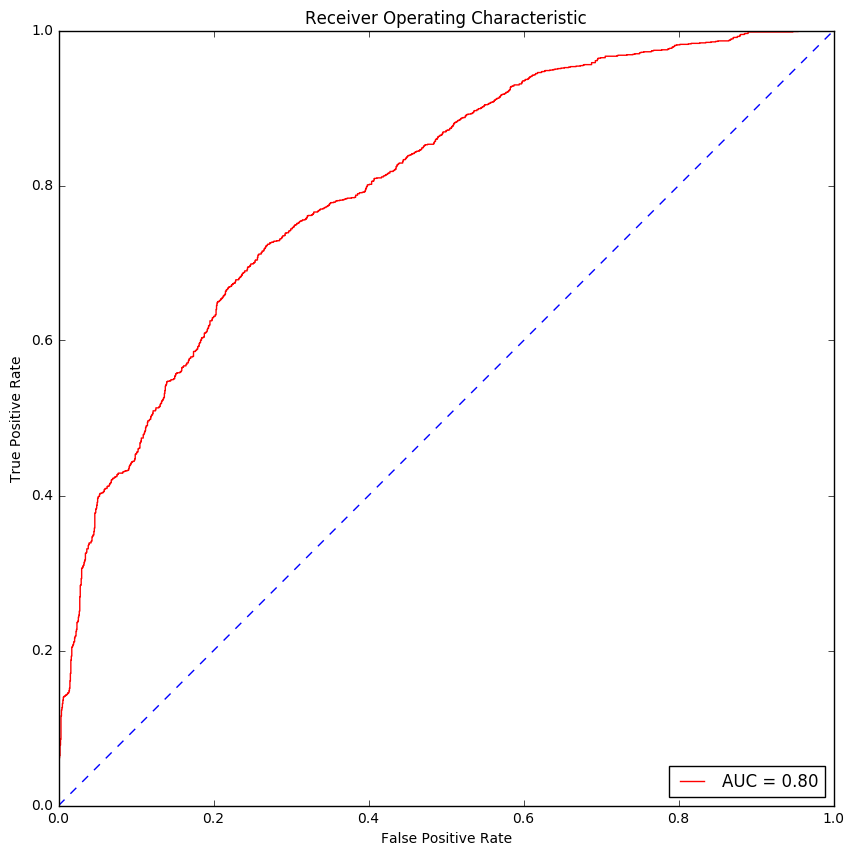

In [180]:
confusion_matrix=metrics.confusion_matrix(y_train,predictions)

auc_roc=metrics.roc_auc_score(y_train,predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, pred_probs[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [181]:
from sklearn.ensemble import RandomForestRegressor
names = df_pred.columns
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))
x = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.1792, 'NWins'), (0.061400000000000003, 'elo_diff'), (0.055100000000000003, 'Wspr'), (0.041000000000000002, 'Wpf'), (0.036299999999999999, 'Lor'), (0.033700000000000001, 'Tfgp15'), (0.033399999999999999, 'Last'), (0.032500000000000001, 'Lspr'), (0.032199999999999999, 'Lpf'), (0.0298, 'Wftm'), (0.029600000000000001, 'tourney_diff'), (0.026700000000000002, 'Lftp'), (0.025399999999999999, 'Lfg3p'), (0.024400000000000002, 'Tfgp5'), (0.024199999999999999, 'Wast'), (0.022800000000000001, 'NLoss'), (0.019400000000000001, 'Lblk'), (0.019199999999999998, 'Wblk'), (0.0189, 'Lto'), (0.0184, 'Wfgp'), (0.017399999999999999, 'Lftm'), (0.015100000000000001, 'Wdr'), (0.0149, 'Tfgp10'), (0.0146, 'Wto'), (0.014500000000000001, 'Wftp'), (0.014500000000000001, 'Wfgm3'), (0.0143, 'Lfgp'), (0.014200000000000001, 'Lfgm'), (0.0141, 'Ldr'), (0.0134, 'Wfg3p'), (0.013299999999999999, 'Wstl'), (0.0129, 'Lfgm3'), (0.0124, 'Wfgm'), (0.0114, 'Lpct'), (0.011299999999999999, 'Wor'), 

In [241]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X_train,y_train)
 
print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))

Features sorted by their rank:
[(1, 'NLoss'), (2, 'Wast'), (3, 'Last'), (4, 'Wpf'), (5, 'Lspr'), (6, 'Wto'), (7, 'Lftp'), (8, 'Lor'), (9, 'Wor'), (10, 'Wspr'), (11, 'Lfgp'), (12, 'Wftp'), (13, 'Lto'), (14, 'Ldr'), (15, 'NWins'), (16, 'Lpf'), (17, 'Lfg3p'), (18, 'Wfgp'), (19, 'Wstl'), (20, 'Wblk'), (21, 'Wdr'), (22, 'Lstl'), (23, 'Wfg3p'), (24, 'Lblk')]


In [242]:
from sklearn.linear_model import RandomizedLasso
from sklearn.datasets import load_boston

rlasso = RandomizedLasso(alpha=0.025)
rlasso.fit(X_train, y_train)
 
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 names), reverse=True))

Features sorted by their score:
[(0.0, 'Wto'), (0.0, 'Wstl'), (0.0, 'Wspr'), (0.0, 'Wpf'), (0.0, 'Wor'), (0.0, 'Wftp'), (0.0, 'Wfgp'), (0.0, 'Wfg3p'), (0.0, 'Wdr'), (0.0, 'Wblk'), (0.0, 'Wast'), (0.0, 'NWins'), (0.0, 'NLoss'), (0.0, 'Lto'), (0.0, 'Lstl'), (0.0, 'Lspr'), (0.0, 'Lpf'), (0.0, 'Lor'), (0.0, 'Lftp'), (0.0, 'Lfgp'), (0.0, 'Lfg3p'), (0.0, 'Ldr'), (0.0, 'Lblk'), (0.0, 'Last')]


In [182]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=50, p=2, weights = 'distance')
kf = KFold(n_splits = 5, shuffle = True, random_state=8)

#print(knn.get_params().keys())

#params = {'C': np.logspace(start=-5, stop=3, num=9)}
# model_LR = GridSearchCV(knn, params, scoring='neg_log_loss', refit=True)
knn.fit(X_train,y_train)

#pred_probs = knn.predict_proba(X_train)
predictions = knn.predict(X_train)

# accuracies = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=kf)
# average_accuracies = np.mean(accuracies)
# print(average_accuracies)

actual = y_train
count= ((predictions-actual)**2).sum()
mse = count/len(actual)
print(mse)

loss = log_loss(y_train, predictions)
print(loss)


0.0
9.99200722163e-16


In [185]:
#predict
df_sample_sub = pd.read_csv(direct+csv[8])

n_test_games = len(df_sample_sub)
print(f_df.shape)

def get_year_t1_t2(id):
    return (int(x) for x in id.split('_'))

# df_diff = create_diff_table(df_tour)
# df_diff.head()

# X_test = np.zeros(shape=(n_test_games, 25))
X_test = pd.DataFrame()
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.id)
    df_calc = f_df[(f_df['Season'] == year)|(f_df['Season'] == year-1)]
    t1_stat = (df_calc.loc[f_df['Team'] == t1]).mean()
    t2_stat = (df_calc.loc[f_df['Team'] == t2]).mean()
    diff = pd.DataFrame(t1_stat.values - t2_stat.values)
    diff = diff.transpose()
    diff['tourney_diff'] = get_tourney_diff(t1,t2,season)
    diff['elo_diff'] = get_elo_diff(t1,t2,season)
    X_test = X_test.append([diff], ignore_index= True)
X_test.head()

#try with 2 seasons, 1 season, no seasons

(2824, 41)


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,tourney_diff,elo_diff
0,0.0,-4.0,-0.074877,-0.047386,-0.039664,-0.009042,-0.005567,-0.072526,0.456838,-0.817594,...,-26.0,0.925490,0.109937,-0.109937,0.233333,0.017362,-0.063016,-0.068140,0,28.0
1,0.0,-9.0,-0.052607,-0.019022,-0.049471,-0.026817,-0.022647,-0.038078,0.514708,-1.090868,...,17.0,-1.947059,-0.064394,0.064394,0.166667,0.022897,-0.036779,-0.038229,-3,-42.0
2,0.0,-22.0,-0.085056,-0.060215,-0.077604,-0.040284,-0.024412,-0.038870,0.960925,0.077472,...,14.0,-0.642585,-0.040224,0.040224,-0.100000,-0.024180,-0.061522,-0.081365,0,88.0
3,0.0,-26.0,-0.039778,-0.026746,-0.020111,-0.019853,-0.018644,-0.048129,1.365096,0.398497,...,-16.0,-0.483751,0.093668,-0.093668,0.433333,0.022640,-0.027171,-0.077474,0,95.0
4,0.0,-34.0,-0.025821,-0.017493,-0.036391,-0.006036,-0.026288,-0.074014,1.963687,-1.934032,...,-18.0,-0.051856,0.091685,-0.091685,-0.033333,0.030538,-0.040226,-0.099062,0,121.0


In [186]:
X_test.drop([0,1],inplace = True, axis =1)
X_test.shape

(9112, 41)

In [187]:
X_test=scaler.fit_transform(X_test)
preds = knn.predict(X_test)

clipped_preds = np.clip(preds, 0.025, 0.975)
df_sample_sub.pred = clipped_preds
df_sample_sub.head(20)

# X_test=scaler.fit_transform(X_test)
# preds = model_LR.predict_proba(X_test)[:,1]

# clipped_preds = np.clip(preds, 0.025, 0.975)
# df_sample_sub.pred = clipped_preds
# df_sample_sub.head(20)

,id,pred
0,2013_1103_1107,0.454598
1,2013_1103_1112,0.265484
2,2013_1103_1125,0.655428
3,2013_1103_1129,0.460445
4,2013_1103_1137,0.669652
5,2013_1103_1139,0.443720
6,2013_1103_1143,0.517919
7,2013_1103_1153,0.221743
8,2013_1103_1160,0.485454
9,2013_1103_1161,0.634471


In [188]:
df_sample_sub.to_csv('danny_mm_17_4_KNN.csv', index=False)

In [97]:
from sklearn.neighbors import KNeighborsRegressor
# Create the knn model.
# i1 = []
# mse1 = []
#for i in range(1,300):
knn = KNeighborsRegressor(n_neighbors=1, algorithm = 'ball_tree', leaf_size = 10)
# Fit the model on the training data.
knn.fit(X_train, y_train)
# Make predictions on the test set using the fit model.
predictions = knn.predict(X_train)
print(predictions)
# for y in range(len(predictions)):
#     if predictions[y] >= 0.5:
#         predictions[y] = 1
#     else:
#         predictions[y] = 0

actual = y_train
count= ((predictions-actual)**2).sum()
mse = count/len(actual)
print(mse)


accuracies = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=10)
average_accuracies = np.mean(accuracies)
print(average_accuracies)


loss = log_loss(y_train, predictions)
print(loss)

# i1.append(i)
# mse1.append(mse)
# print(predictions)
#print(i1)

[ 1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.  0.
  1.  1.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.
  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.  1.  1.
  0.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.
  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.  0.
  0.  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  0.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.
  0.  1.  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  0.  0.
  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.  1.  1

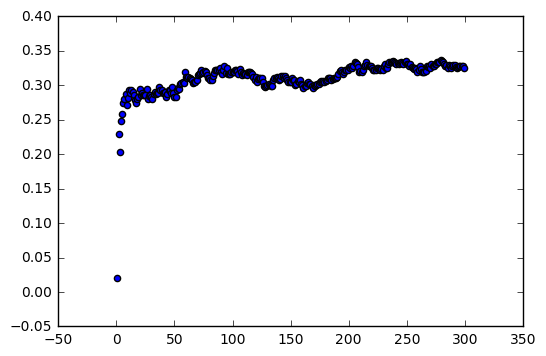

In [291]:
plt.scatter(i1,mse1)